In [ ]:
import pandas as pd
import numpy as np

# ✅ 1) Load Amazon 5-core JSON (JSON Lines format)
path = "/content/Luxury_Beauty_5.json"   # adjust if your filename/path differs

df = pd.read_json(path, lines=True)
print(df.shape)
df.head()


(34278, 12)


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN


In [ ]:
# --- imports ---
import pandas as pd
import numpy as np

# adjust if your file path is different
path = "/content/Luxury_Beauty_5.json"

# 1) load
df = pd.read_json(path, lines=True)
print("raw shape:", df.shape)

# 2) quick peek of columns and dtypes
print(df.dtypes)
print(df.columns.tolist())

# 3) keep only the useful columns and rename
df = df[["reviewerID", "asin", "overall", "unixReviewTime",
         "verified", "reviewText", "summary", "vote"]].copy()

df.rename(columns={
    "reviewerID": "user_id",
    "asin": "item_id",
    "overall": "rating",
    "unixReviewTime": "timestamp",
    "reviewText": "review_text",
    "summary": "summary",
    "vote": "vote"
}, inplace=True)

# 4) basic cleaning + types
df = df.dropna(subset=["user_id", "item_id", "rating", "timestamp"])
df["rating"] = df["rating"].astype(float)
df["timestamp"] = df["timestamp"].astype(int)
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")

# 5) dedupe same user-item: keep most recent (last)
df = df.sort_values("timestamp").drop_duplicates(["user_id", "item_id"], keep="last").reset_index(drop=True)

print("after cleaning:", df.shape)
display(df.head())

# ---- Quick EDA ----
print("unique users:", df["user_id"].nunique())
print("unique items:", df["item_id"].nunique())
print("interactions:", len(df))
print("density (interactions / (users*items)):", len(df) / (df["user_id"].nunique()*df["item_id"].nunique()))

# rating distribution
print(df["rating"].value_counts().sort_index())

# top items / top users
print("\nTop 10 items by interactions:")
print(df["item_id"].value_counts().head(10))

print("\nTop 10 users by interactions:")
print(df["user_id"].value_counts().head(10))

# interactions per user statistics
iu = df.groupby("user_id").size()
print("\ninteractions per user: mean %.2f  median %.2f  max %d" % (iu.mean(), iu.median(), iu.max()))

# ---- Map to int ids for modeling ----
user_ids = df["user_id"].unique()
item_ids = df["item_id"].unique()

user2idx = {u:i for i,u in enumerate(user_ids)}
item2idx = {i:i2 for i2,i in enumerate(item_ids)}  # careful naming

df["user_idx"] = df["user_id"].map(user2idx).astype(int)
df["item_idx"] = df["item_id"].map(item2idx).astype(int)

n_users = df["user_idx"].nunique()
n_items = df["item_idx"].nunique()
print(f"\nMapped to indices -> users: {n_users}, items: {n_items}")

# Save mapping (optional)
# pd.Series(user2idx).to_frame("idx").reset_index().rename(columns={"index":"user_id"}).to_csv("user2idx.csv", index=False)
# pd.Series(item2idx).to_frame("idx").reset_index().rename(columns={"index":"item_id"}).to_csv("item2idx.csv", index=False)

# ---- Splitting: TWO OPTIONS ----
# Option A: Global time-based 80/10/10
def global_time_split(df, train_frac=0.8, val_frac=0.1):
    df_sorted = df.sort_values("timestamp").reset_index(drop=True)
    n = len(df_sorted)
    train_end = int(train_frac * n)
    val_end   = int((train_frac + val_frac) * n)
    train = df_sorted.iloc[:train_end].copy()
    val   = df_sorted.iloc[train_end:val_end].copy()
    test  = df_sorted.iloc[val_end:].copy()
    return train, val, test

# Option B (recommended): Per-user leave-last-two
def per_user_leave_last_k(df, k=2):
    # For each user, sort their interactions by time and keep:
    # all except last k -> train, last k-1 -> val, last 1 -> test (if k==2 => last-1 val, last test)
    df = df.sort_values(["user_idx", "timestamp"])
    train_list, val_list, test_list = [], [], []
    for user, user_df in df.groupby("user_idx"):
        if len(user_df) < k+1:
            # if user too small, put all interactions in train (alternatively drop)
            train_list.append(user_df)
            continue
        # keep all but last k in train
        train_list.append(user_df.iloc[:-k])
        # from last k: keep second-last as val and last as test
        if k >= 2:
            val_list.append(user_df.iloc[[-k]])
            test_list.append(user_df.iloc[[-1]])
        else:
            # k==1 -> put last as test, val empty
            test_list.append(user_df.iloc[[-1]])
    train = pd.concat(train_list).reset_index(drop=True)
    val   = pd.concat(val_list).reset_index(drop=True) if val_list else pd.DataFrame(columns=df.columns)
    test  = pd.concat(test_list).reset_index(drop=True) if test_list else pd.DataFrame(columns=df.columns)
    return train, val, test

# choose your split:
#train, val, test = global_time_split(df)     # use global split
train, val, test = per_user_leave_last_k(df, k=2)  # recommended

print("\nSplit sizes -> train:", len(train), "val:", len(val), "test:", len(test))

# Optional: ensure val/test only contain users/items seen in train
train_users = set(train["user_idx"])
train_items = set(train["item_idx"])
val = val[val["user_idx"].isin(train_users) & val["item_idx"].isin(train_items)].reset_index(drop=True)
test = test[test["user_idx"].isin(train_users) & test["item_idx"].isin(train_items)].reset_index(drop=True)
print("After filtering unseen in train -> val:", len(val), "test:", len(test))

# Save CSVs for training
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)
print("Saved train/val/test csv")


raw shape: (34278, 12)
overall             int64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote              float64
image              object
dtype: object
['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote', 'image']
after cleaning: (28074, 9)


,user_id,item_id,rating,timestamp,verified,review_text,summary,vote,datetime
0,A3CJ7MHAS9IMAM,B000MIH34Q,4.0,1127174400,False,I was in Nordstroms when they were having a Ja...,"Great product, Less than ideal packaging",53.0,2005-09-20
1,A281NPSIMI1C2R,B000248HLI,5.0,1152144000,False,"""Strivectin-SD is much less expensive than sur...",Lasts a long time...,35.0,2006-07-06
2,A281NPSIMI1C2R,B009FKGDHU,5.0,1157587200,False,Nuxe's hydrating energizing moisturizer is a r...,Moringa Oil - Luxurious,3.0,2006-09-07
3,AIIR8E34EDKCQ,B000VOJPMY,5.0,1168905600,False,I have always thought the decanter holding the...,Kingdom of true beauty,5.0,2007-01-16
4,A2SH7OWE8QJYNC,B000Z5YFX8,3.0,1172361600,False,I bought the 5-Day Detox kit so I could try a ...,"Cooling, but not as moisturizing as I'd like",NaN,2007-02-25


unique users: 3819
unique items: 1581
interactions: 28074
density (interactions / (users*items)): 0.004649676813177695
rating
1.0      940
2.0     1326
3.0     3435
4.0     6829
5.0    15544
Name: count, dtype: int64

Top 10 items by interactions:
item_id
B000J4FGAG    440
B0006PLMFQ    440
B007PORYUI    439
B0058TE4WI    439
B00B59AULY    439
B00699JDKY    438
B00DTH63P2    420
B00BXS9PFE    420
B003OGV7UO    286
B004N2S2JM    286
Name: count, dtype: int64

Top 10 users by interactions:
user_id
A2V5R832QCSOMX    90
AQY5XBYSENNZQ     89
A3091RP0SPZLMN    79
AHN86VFJIJ2JP     79
A2OW1FKQFPIA5D    78
A2YKWYC3WQJX5J    62
A2LW5AL0KQ9P1M    58
A2GJX2KCUSR0EI    56
A15T9G38F589KM    52
AOEUN9718KVRD     52
Name: count, dtype: int64

interactions per user: mean 7.35  median 5.00  max 90

Mapped to indices -> users: 3819, items: 1581

Split sizes -> train: 20796 val: 3639 test: 3639
After filtering unseen in train -> val: 3601 test: 3542
Saved train/val/test csv


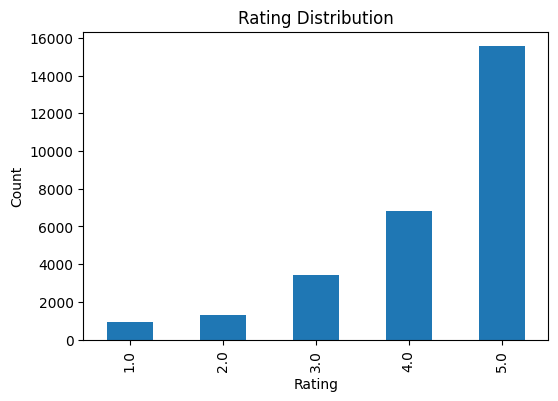

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


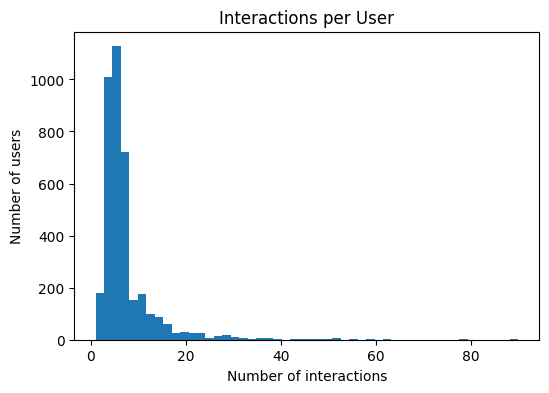

In [ ]:
user_interactions = df.groupby("user_id").size()

plt.figure(figsize=(6,4))
plt.hist(user_interactions, bins=50)
plt.title("Interactions per User")
plt.xlabel("Number of interactions")
plt.ylabel("Number of users")
plt.show()


In [ ]:
num_users = df["user_id"].nunique()
num_items = df["item_id"].nunique()
num_interactions = len(df)

sparsity = 1 - (num_interactions / (num_users * num_items))

print(f"Users: {num_users}")
print(f"Items: {num_items}")
print(f"Interactions: {num_interactions}")
print(f"Sparsity: {sparsity:.4f}")


Users: 3819
Items: 1581
Interactions: 28074
Sparsity: 0.9954


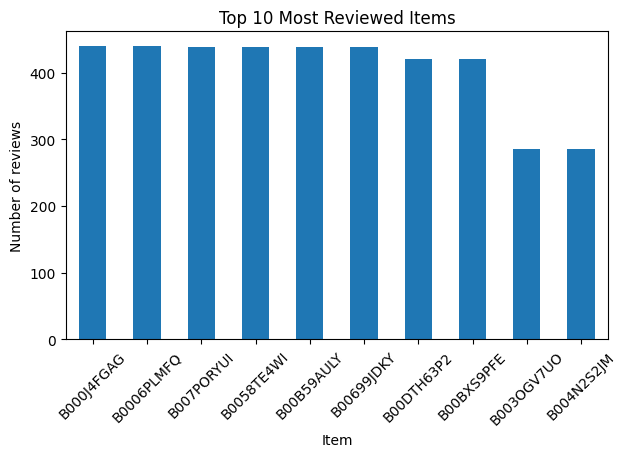

In [ ]:
top_items = df["item_id"].value_counts().head(10)

plt.figure(figsize=(7,4))
top_items.plot(kind="bar")
plt.title("Top 10 Most Reviewed Items")
plt.xlabel("Item")
plt.ylabel("Number of reviews")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# -------- common_setup_and_eval.py --------
# Install libraries if needed:
# pip install pandas numpy scipy scikit-learn implicit surprise tqdm

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from collections import defaultdict
from sklearn.preprocessing import normalize
from tqdm.auto import tqdm

# Paths (adjust if needed)
PATH_TRAIN = "train.csv"
PATH_VAL   = "val.csv"
PATH_TEST  = "test.csv"

# Load
train = pd.read_csv(PATH_TRAIN)
val   = pd.read_csv(PATH_VAL)
test  = pd.read_csv(PATH_TEST)

# We'll use integer indices 'user_idx' and 'item_idx'. If not present, create maps:
if "user_idx" not in train.columns:
    users = pd.concat([train['user_id'], val['user_id'], test['user_id']]).unique()
    user2idx = {u:i for i,u in enumerate(users)}
    for df in [train, val, test]:
        df['user_idx'] = df['user_id'].map(user2idx).astype(int)
if "item_idx" not in train.columns:
    items = pd.concat([train['item_id'], val['item_id'], test['item_id']]).unique()
    item2idx = {it:i for i,it in enumerate(items)}
    for df in [train, val, test]:
        df['item_idx'] = df['item_id'].map(item2idx).astype(int)

n_users = max(train['user_idx'].max(), val['user_idx'].max(), test['user_idx'].max()) + 1
n_items = max(train['item_idx'].max(), val['item_idx'].max(), test['item_idx'].max()) + 1

print("n_users", n_users, "n_items", n_items)

# Build user -> set(items) for train, val, test for quick lookup
train_ur = train.groupby('user_idx')['item_idx'].apply(set).to_dict()
val_ur   = val.groupby('user_idx')['item_idx'].apply(set).to_dict()
test_ur  = test.groupby('user_idx')['item_idx'].apply(set).to_dict()

# Ensure every user in val/test exists in train_users (if not, they'll be skipped in eval)
train_users = set(train_ur.keys())

# Candidate sampler: for each user, candidates = all items not in train_user_items.
# For scalable eval, we generate candidate list per user by sampling negatives + positives.
def get_candidate_items(user, n_samples=1000, rng=np.random):
    """Return candidate items (1 positive in test/val, rest negatives).
       We'll sample negatives uniformly from all items not seen in train for that user.
       This function is used in ranking evaluation where full-scan would be expensive.
    """
    train_items = train_ur.get(user, set())
    pos_items = test_ur.get(user, set())  # test positives (might be >1)
    # create pool of negatives (items not in user's train and not positives)
    negatives_pool = np.setdiff1d(np.arange(n_items), np.fromiter(train_items.union(pos_items), dtype=int), assume_unique=False)
    if len(negatives_pool) == 0:
        return np.array([], dtype=int)
    n_neg = max(0, n_samples - len(pos_items))
    sampled_neg = rng.choice(negatives_pool, size=min(n_neg, len(negatives_pool)), replace=False)
    candidates = np.concatenate([np.fromiter(pos_items, dtype=int), sampled_neg])
    return candidates

# Ranking metrics
def precision_at_k(ranked, ground_truth, k):
    ranked_k = ranked[:k]
    return len(set(ranked_k) & set(ground_truth)) / k

def recall_at_k(ranked, ground_truth, k):
    ranked_k = ranked[:k]
    return len(set(ranked_k) & set(ground_truth)) / len(ground_truth) if len(ground_truth)>0 else 0.0

def dcg_at_k(ranked, ground_truth, k):
    ranked_k = ranked[:k]
    gains = [1.0 if item in ground_truth else 0.0 for item in ranked_k]
    discounts = [1.0] + [1.0/np.log2(i+1) for i in range(2, k+1)]
    return np.sum(np.array(gains) * np.array(discounts))

def ndcg_at_k(ranked, ground_truth, k):
    dcg = dcg_at_k(ranked, ground_truth, k)
    # ideal DCG: all ground_truth at top
    ideal_gains = [1.0]*min(len(ground_truth), k)
    if len(ideal_gains) == 0:
        return 0.0
    discounts = [1.0] + [1.0/np.log2(i+1) for i in range(2, k+1)]
    idcg = np.sum(np.array(ideal_gains) * np.array(discounts[:len(ideal_gains)]))
    return dcg / idcg if idcg>0 else 0.0

# Evaluate function that takes a function `score_items(user, candidates)` returning scores array aligned with candidates.
def evaluate_model(score_items_fn, users_to_eval=None, K=10, candidates_per_user=1000, rng=np.random):
    users = users_to_eval if users_to_eval is not None else list(test_ur.keys())
    metrics = {"prec@K": [], "rec@K": [], "ndcg@K": []}
    for user in tqdm(users, desc="Evaluating users"):
        if user not in train_users:
            continue  # skip cold-start users
        ground_truth = test_ur.get(user, set())
        if len(ground_truth) == 0:
            continue
        candidates = get_candidate_items(user, n_samples=candidates_per_user, rng=rng)
        if len(candidates) == 0:
            continue
        scores = score_items_fn(user, candidates)  # numpy array same length
        idx_sorted = np.argsort(-scores)  # descending
        ranked = candidates[idx_sorted]
        metrics["prec@K"].append(precision_at_k(ranked, ground_truth, K))
        metrics["rec@K"].append(recall_at_k(ranked, ground_truth, K))
        metrics["ndcg@K"].append(ndcg_at_k(ranked, ground_truth, K))
    # average metrics
    return {k: float(np.mean(v)) if len(v)>0 else 0.0 for k,v in metrics.items()}


n_users 3819 n_items 1577


In [ ]:
# Full end-to-end pipeline (run this cell in Colab / local)
# - Loads train.csv / val.csv / test.csv
# - Ensures indices are sized using max_index + 1 (fix for IndexError)
# - SVD-style MF (SGD) baseline
# - ALS (implicit) if implicit package available (pip install implicit)
# - Ranking evaluation (Precision@K, Recall@K, NDCG@K) with negative sampling
# - Saves models and prints a sample top-K recommendation
# NOTE: adjust small hyperparams for your dataset size.

# If running in Colab and you want ALS, uncomment the next line:
# !pip install implicit

import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from tqdm.auto import tqdm
import pickle

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# ---------------------------
# 1) Load CSVs
# ---------------------------
def load_datasets(train_path="train.csv", val_path="val.csv", test_path="test.csv"):
    train = pd.read_csv(train_path)
    val   = pd.read_csv(val_path)
    test  = pd.read_csv(test_path)
    return train, val, test

train, val, test = load_datasets()

# If user_idx/item_idx missing, create contiguous indices across all splits
if "user_idx" not in train.columns or "item_idx" not in train.columns:
    all_users = pd.concat([train['user_id'], val['user_id'], test['user_id']]).unique()
    user2idx = {u:i for i,u in enumerate(all_users)}
    all_items = pd.concat([train['item_id'], val['item_id'], test['item_id']]).unique()
    item2idx = {it:i for i,it in enumerate(all_items)}
    for df in [train, val, test]:
        df['user_idx'] = df['user_id'].map(user2idx).astype(int)
        df['item_idx'] = df['item_id'].map(item2idx).astype(int)

# IMPORTANT: compute sizes using max_index + 1 (fix)
n_users = int(max(train['user_idx'].max(), val['user_idx'].max(), test['user_idx'].max()) + 1)
n_items = int(max(train['item_idx'].max(), val['item_idx'].max(), test['item_idx'].max()) + 1)
print("n_users:", n_users, "n_items:", n_items, "interactions(train):", len(train))

# Build user->set(item) dictionaries
train_ur = train.groupby('user_idx')['item_idx'].apply(set).to_dict()
val_ur   = val.groupby('user_idx')['item_idx'].apply(set).to_dict()
test_ur  = test.groupby('user_idx')['item_idx'].apply(set).to_dict()
train_users = set(train_ur.keys())

# Basic sanity checks
assert train['user_idx'].min() >= 0 and train['item_idx'].min() >= 0, "Negative indices found"
assert train['user_idx'].max() < n_users and train['item_idx'].max() < n_items, "Index max exceeds declared n_users/n_items"

# ---------------------------
# 2) Evaluation utilities (negative sampling)
# ---------------------------
def get_candidate_items(user, n_items_total, n_samples=1000, rng=np.random):
    """Return candidate items: (test positives) + sampled negatives not in train for user."""
    train_items = train_ur.get(user, set())
    pos_items = test_ur.get(user, set())
    all_items = np.arange(n_items_total, dtype=int)
    exclude = np.fromiter(train_items.union(pos_items), dtype=int) if len(train_items.union(pos_items))>0 else np.array([], dtype=int)
    neg_pool = np.setdiff1d(all_items, exclude, assume_unique=False)
    n_neg = max(0, n_samples - len(pos_items))
    if len(neg_pool) == 0 or n_neg == 0:
        sampled_neg = np.array([], dtype=int)
    else:
        sampled_neg = rng.choice(neg_pool, size=min(n_neg, len(neg_pool)), replace=False)
    candidates = np.concatenate([np.fromiter(pos_items, dtype=int), sampled_neg])
    return candidates

def precision_at_k(ranked, ground_truth, k):
    return len(set(ranked[:k]) & set(ground_truth)) / k

def recall_at_k(ranked, ground_truth, k):
    return 0.0 if len(ground_truth)==0 else len(set(ranked[:k]) & set(ground_truth)) / len(ground_truth)

def dcg_at_k(ranked, ground_truth, k):
    ranked_k = ranked[:k]
    gains = [1.0 if item in ground_truth else 0.0 for item in ranked_k]
    discounts = [1.0] + [1.0/np.log2(i+1) for i in range(2, k+1)]
    return np.sum(np.array(gains) * np.array(discounts))

def ndcg_at_k(ranked, ground_truth, k):
    if len(ground_truth) == 0:
        return 0.0
    dcg = dcg_at_k(ranked, ground_truth, k)
    ideal_gains = [1.0]*min(len(ground_truth), k)
    discounts = [1.0] + [1.0/np.log2(i+1) for i in range(2, k+1)]
    idcg = np.sum(np.array(ideal_gains) * np.array(discounts[:len(ideal_gains)]))
    return dcg / idcg if idcg>0 else 0.0

def evaluate_model(score_items_fn, users_to_eval=None, K=10, candidates_per_user=1000, rng=np.random):
    users = users_to_eval if users_to_eval is not None else list(test_ur.keys())
    metrics = {"prec@K": [], "rec@K": [], "ndcg@K": []}
    for user in tqdm(users, desc="Evaluating users"):
        if user not in train_users:
            continue
        gt = test_ur.get(user, set())
        if len(gt) == 0:
            continue
        candidates = get_candidate_items(user, n_items_total=n_items, n_samples=candidates_per_user, rng=rng)
        if len(candidates) == 0:
            continue
        scores = score_items_fn(user, candidates)
        idx_sorted = np.argsort(-scores)
        ranked = candidates[idx_sorted]
        metrics["prec@K"].append(precision_at_k(ranked, gt, K))
        metrics["rec@K"].append(recall_at_k(ranked, gt, K))
        metrics["ndcg@K"].append(ndcg_at_k(ranked, gt, K))
    return {k: float(np.mean(v)) if len(v)>0 else 0.0 for k,v in metrics.items()}

# ---------------------------
# 3) SVD-style MF (SGD) : explicit baseline (uses n_users,n_items for sizing)
# ---------------------------
def train_svd_sgd(train_df, n_users, n_items, n_factors=64, lr=0.01, reg=0.05, n_epochs=10, verbose=True):
    """
    Train explicit MF with biases using SGD.
    IMPORTANT: pass n_users and n_items (max_index+1 across all splits).
    """
    mu = train_df['rating'].mean()
    rng_local = np.random.default_rng(RANDOM_SEED)
    P = rng_local.normal(0, 0.1, size=(n_users, n_factors))
    Q = rng_local.normal(0, 0.1, size=(n_items, n_factors))
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)

    users = train_df['user_idx'].to_numpy(dtype=int)
    items = train_df['item_idx'].to_numpy(dtype=int)
    ratings = train_df['rating'].to_numpy(dtype=float)

    for epoch in range(n_epochs):
        perm = rng_local.permutation(len(ratings))
        err = 0.0
        for idx in perm:
            u = users[idx]
            i = items[idx]
            r = ratings[idx]
            pred = mu + bu[u] + bi[i] + P[u].dot(Q[i])
            e = r - pred
            err += e**2
            # updates
            bu[u] += lr * (e - reg * bu[u])
            bi[i] += lr * (e - reg * bi[i])
            Pu = P[u].copy()
            Qi = Q[i].copy()
            P[u] += lr * (e * Qi - reg * Pu)
            Q[i] += lr * (e * Pu - reg * Qi)
        rmse = np.sqrt(err / len(ratings))
        if verbose:
            print(f"SVD (SGD) Epoch {epoch+1}/{n_epochs} RMSE={rmse:.4f}")
    model = {"P": P, "Q": Q, "bu": bu, "bi": bi, "mu": mu}
    return model

def svd_score_items(model, user, candidates):
    P, Q, bu, bi, mu = model['P'], model['Q'], model['bu'], model['bi'], model['mu']
    q_cands = Q[candidates]
    uvec = P[user]
    preds = mu + bu[user] + bi[candidates] + q_cands.dot(uvec)
    return preds

# ---------------------------
# 4) ALS (implicit) - optional (will attempt to import)
# ---------------------------
implicit_available = False
try:
    import implicit
    implicit_available = True
except Exception as e:
    print("implicit not available (to use ALS, run: pip install implicit). Error:", e)

def train_als_implicit(train_df, n_users, n_items, use_gpu=False, factors=64, regularization=0.01, iterations=20, alpha=40.0, verbose=True):
    """Train implicit ALS (implicit library). Builds item-user matrix internally."""
    df = train_df.copy()
    # implicit label: treat rating>=4 as positive; adjust threshold if needed
    df['implicit'] = (df['rating'] >= 4).astype(float)
    rows = df['item_idx'].astype(int).values
    cols = df['user_idx'].astype(int).values
    data = df['implicit'].astype(float).values
    item_user = csr_matrix((data, (rows, cols)), shape=(n_items, n_users)).astype('float32')
    model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations, use_gpu=use_gpu)
    confidence = (item_user * alpha).astype('float32')
    if verbose:
        print("Fitting ALS with factors", factors, "reg", regularization, "iter", iterations, "alpha", alpha)
    model.fit(confidence)
    return model

def als_score_items(model, user, candidates):
    uvec = model.user_factors[user]
    iv = model.item_factors[candidates]
    return iv.dot(uvec)

# ---------------------------
# 5) Train & validate (small hyperparam choices)
# ---------------------------
# Tuneable hyperparams (start small; scale up)
svd_params = {"n_factors": 64, "lr": 0.01, "reg": 0.05, "n_epochs": 8}
als_params = {"factors": 64, "regularization": 0.01, "iterations": 15, "alpha": 40.0, "use_gpu": False}

print("\nTraining SVD (SGD) baseline...")
svd_model = train_svd_sgd(train, n_users=n_users, n_items=n_items,
                          n_factors=svd_params["n_factors"], lr=svd_params["lr"],
                          reg=svd_params["reg"], n_epochs=svd_params["n_epochs"], verbose=True)

print("\nEvaluating SVD on validation (ranking metrics)...")
svd_val_metrics = evaluate_model(lambda u, c: svd_score_items(svd_model, u, c),
                                 users_to_eval=list(val_ur.keys()), K=10, candidates_per_user=1000, rng=np.random.RandomState(123))
print("SVD Val metrics:", svd_val_metrics)

als_val_metrics = None
if implicit_available:
    print("\nTraining ALS (implicit)...")
    als_model = train_als_implicit(train, n_users=n_users, n_items=n_items,
                                   use_gpu=als_params["use_gpu"], factors=als_params["factors"],
                                   regularization=als_params["regularization"],
                                   iterations=als_params["iterations"], alpha=als_params["alpha"], verbose=True)

    print("\nEvaluating ALS on validation (ranking metrics)...")
    als_val_metrics = evaluate_model(lambda u, c: als_score_items(als_model, u, c),
                                     users_to_eval=list(val_ur.keys()), K=10, candidates_per_user=1000, rng=np.random.RandomState(123))
    print("ALS Val metrics:", als_val_metrics)
else:
    print("ALS skipped (implicit not installed).")

# ---------------------------
# 6) Select best model by val NDCG and evaluate on test
# ---------------------------
best_model_name = "SVD"
best_model_obj = svd_model
if implicit_available and als_val_metrics is not None:
    if als_val_metrics['ndcg@K'] >= svd_val_metrics['ndcg@K']:
        best_model_name = "ALS"
        best_model_obj = als_model

print("\nSelected best model based on val NDCG:", best_model_name)

if best_model_name == "SVD":
    test_metrics = evaluate_model(lambda u, c: svd_score_items(best_model_obj, u, c),
                                  users_to_eval=list(test_ur.keys()), K=10, candidates_per_user=1000, rng=np.random.RandomState(456))
else:
    test_metrics = evaluate_model(lambda u, c: als_score_items(best_model_obj, u, c),
                                  users_to_eval=list(test_ur.keys()), K=10, candidates_per_user=1000, rng=np.random.RandomState(456))

print(f"\nTest metrics for {best_model_name}:", test_metrics)

# ---------------------------
# 7) Save models & sample recommendations
# ---------------------------
os.makedirs("models", exist_ok=True)
with open("models/svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)
if implicit_available and best_model_name == "ALS":
    # Save ALS model state
    try:
        als_model.save("models/als_model.npz")
    except Exception:
        pass

print("Models saved to models/ (svd_model.pkl and optionally als_model.npz)")

# Sample top-K for a sample train user
sample_user = next(iter(train_ur.keys()))
print("\nSample user id:", sample_user)
cands = np.setdiff1d(np.arange(n_items), np.fromiter(train_ur[sample_user], dtype=int), assume_unique=False)
# For memory reasons, if n_items is very large, sample a subset of candidates (but this approximates).
# Here we score all candidates if feasible.
if best_model_name == "SVD":
    scores = svd_score_items(svd_model, sample_user, cands)
else:
    scores = als_score_items(best_model_obj, sample_user, cands)
topk_idx = np.argsort(-scores)[:10]
topk_items = cands[topk_idx]
print("Top-10 recommended item_idx for sample user:", topk_items)


n_users: 3819 n_items: 1577 interactions(train): 20796
implicit not available (to use ALS, run: pip install implicit). Error: No module named 'implicit'

Training SVD (SGD) baseline...
SVD (SGD) Epoch 1/8 RMSE=1.0185
SVD (SGD) Epoch 2/8 RMSE=0.9643
SVD (SGD) Epoch 3/8 RMSE=0.9197
SVD (SGD) Epoch 4/8 RMSE=0.8799
SVD (SGD) Epoch 5/8 RMSE=0.8427
SVD (SGD) Epoch 6/8 RMSE=0.8075
SVD (SGD) Epoch 7/8 RMSE=0.7755
SVD (SGD) Epoch 8/8 RMSE=0.7477

Evaluating SVD on validation (ranking metrics)...


Evaluating users:   0%|          | 0/3601 [00:00<?, ?it/s]

SVD Val metrics: {'prec@K': 0.003077799943003705, 'rec@K': 0.030777999430037048, 'ndcg@K': 0.01410616579230425}
ALS skipped (implicit not installed).

Selected best model based on val NDCG: SVD


Evaluating users:   0%|          | 0/3542 [00:00<?, ?it/s]


Test metrics for SVD: {'prec@K': 0.0033596837944664033, 'rec@K': 0.03359683794466403, 'ndcg@K': 0.015213468950795016}
Models saved to models/ (svd_model.pkl and optionally als_model.npz)

Sample user id: 0
Top-10 recommended item_idx for sample user: [   7 1505 1353  254  875 1427  413  274  406 1091]
